In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
patients = pd.read_csv('../data/raw/patients.csv')
encounters = pd.read_csv('../data/raw/encounters.csv')
conditions = pd.read_csv('../data/raw/conditions.csv')

In [3]:
# CREATE READMISSION DATA (IMPROVED METHOD from first notebook)
def calculate_readmission_data(encounters_df):
    inpatient_encounters = encounters_df[encounters_df['ENCOUNTERCLASS'] == 'inpatient'].copy()
    inpatient_encounters['START'] = pd.to_datetime(inpatient_encounters['START'])
    inpatient_encounters['STOP'] = pd.to_datetime(inpatient_encounters['STOP'])
    inpatient_encounters['length_of_stay'] = (inpatient_encounters['STOP'] - inpatient_encounters['START']).dt.days
    
    readmission_data = inpatient_encounters[inpatient_encounters['length_of_stay'] <= 30].copy()
    readmission_data = readmission_data.sort_values(['PATIENT', 'START']).copy()
    
    # Only patients with multiple admissions
    patient_admission_counts = readmission_data['PATIENT'].value_counts()
    patients_with_multiple_admissions = patient_admission_counts[patient_admission_counts > 1].index
    readmission_analysis_data = readmission_data[readmission_data['PATIENT'].isin(patients_with_multiple_admissions)].copy()
    
    # next_admission_date
    readmission_analysis_data['next_admission_date'] = readmission_analysis_data.groupby('PATIENT')['START'].shift(-1)
    eligible_discharges = readmission_analysis_data[readmission_analysis_data['next_admission_date'].notna()].copy()
    
    # Readmission calculation (excluding same-day transfers)
    eligible_discharges['days_to_readmit'] = (eligible_discharges['next_admission_date'] - eligible_discharges['STOP']).dt.days
    eligible_discharges['readmission_30_days'] = (
        (eligible_discharges['days_to_readmit'] <= 30) & 
        (eligible_discharges['days_to_readmit'] > 0)  # excluding same-day transfers
    )
    
    return eligible_discharges

In [4]:
readmission_data = calculate_readmission_data(encounters)
print(f"IMPROVED Readmission data: {len(readmission_data)} eligible discharges")
print(f"CORRECT Readmission rate: {readmission_data['readmission_30_days'].mean()*100:.2f}%")

IMPROVED Readmission data: 1439 eligible discharges
CORRECT Readmission rate: 27.52%


In [5]:
# Merge with patients demographic data (IMPROVED veriyle)
readmission_with_demo = readmission_data.merge(
    patients[['Id','GENDER','RACE','ETHNICITY','BIRTHDATE','MARITAL']],
    left_on = 'PATIENT',
    right_on = 'Id',
    how = 'left'
)

# Calculate age at admission
readmission_with_demo['START'] = pd.to_datetime(readmission_with_demo['START']).dt.tz_localize(None)
readmission_with_demo['BIRTHDATE'] = pd.to_datetime(readmission_with_demo['BIRTHDATE']).dt.tz_localize(None)
readmission_with_demo['age_at_admission'] = (
    readmission_with_demo['START'] - readmission_with_demo['BIRTHDATE']
).dt.days // 365

print(f"Merged data: {len(readmission_with_demo)} records")
print(f"Readmission rate: {readmission_with_demo['readmission_30_days'].mean()*100:.2f}%")


Merged data: 1439 records
Readmission rate: 27.52%


In [6]:
# readmission analysis by age group
# we are looking for an answer to Are elderly patients at higher risk?

# Create age groups
readmission_with_demo['age_group'] = pd.cut(
    readmission_with_demo['age_at_admission'],
    bins=[0, 18, 35, 50, 65, 100],
    labels=['0-18', '19-35', '36-50', '51-65', '65+']
)

# Calculate readmission rates by age group
age_analysis = readmission_with_demo.groupby('age_group').agg({
    'readmission_30_days': ['count', 'mean', 'sum']
}).round(4)

# Rename columns
age_analysis.columns = ['total_admissions', 'readmission_rate', 'readmission_count']
age_analysis['readmission_rate_%'] = (age_analysis['readmission_rate'] * 100).round(2)

print(age_analysis[['total_admissions', 'readmission_count', 'readmission_rate_%']])

           total_admissions  readmission_count  readmission_rate_%
age_group                                                         
0-18                     81                  0                0.00
19-35                   105                  0                0.00
36-50                   212                 57               26.89
51-65                   642                226               35.20
65+                     398                113               28.39


C:\Users\DELL\AppData\Local\Temp\ipykernel_6652\2560944712.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_analysis = readmission_with_demo.groupby('age_group').agg({


In [7]:
# readmission analysis by gender 

# group by gender and calculate readmission rates
gender_analysis = readmission_with_demo.groupby('GENDER').agg({
    'readmission_30_days': ['count', 'mean', 'sum']
}).round(4)

# Rename columns
gender_analysis.columns = ['total_admissions', 'readmission_rate', 'readmission_count']
gender_analysis['readmission_rate_%'] = (gender_analysis['readmission_rate'] * 100).round(2)

print(gender_analysis[['total_admissions', 'readmission_count', 'readmission_rate_%']])

        total_admissions  readmission_count  readmission_rate_%
GENDER                                                         
F                    836                190               22.73
M                    603                206               34.16


In [8]:
# readmission analysis by rate 

race_analysis = readmission_with_demo.groupby('RACE').agg({
    'readmission_30_days':['count','mean','sum']
}).round(4)

# rename coloumns
race_analysis.columns = ['total_admissions', 'readmission_rate', 'readmission_count']
race_analysis['readmission_rate_%'] = (race_analysis['readmission_rate'] * 100).round(2)
print(race_analysis[['total_admissions', 'readmission_count', 'readmission_rate_%']].sort_values('readmission_rate_%', ascending=False))

       total_admissions  readmission_count  readmission_rate_%
RACE                                                          
black               218                 71               32.57
white              1160                325               28.02
asian                61                  0                0.00


In [9]:
# chronic disease analysis
top_conditions = conditions['DESCRIPTION'].value_counts().head(30)
print(top_conditions)

DESCRIPTION
Full-time employment (finding)                               13805
Stress (finding)                                              5137
Part-time employment (finding)                                2426
Social isolation (finding)                                    1243
Viral sinusitis (disorder)                                    1233
Limited social contact (finding)                              1200
Not in labor force (finding)                                  1077
Victim of intimate partner abuse (finding)                     819
Acute viral pharyngitis (disorder)                             678
Acute bronchitis (disorder)                                    571
Reports of violence in the environment (finding)               565
Normal pregnancy                                               527
Received higher education (finding)                            523
Body mass index 30+ - obesity (finding)                        463
Risk activity involvement (finding)               

In [10]:
# Filter conditions where DESCRIPTION contains "disorder"
disorder_conditions = conditions[conditions['DESCRIPTION'].str.contains('disorder', case=False, na=False)]

# Show top 20 most frequent disorder diseases
top_disorders = disorder_conditions['DESCRIPTION'].value_counts().head(20)
print(top_disorders)

DESCRIPTION
Viral sinusitis (disorder)                     1233
Acute viral pharyngitis (disorder)              678
Acute bronchitis (disorder)                     571
Anemia (disorder)                               324
Chronic sinusitis (disorder)                    219
Streptococcal sore throat (disorder)            162
Acute bacterial sinusitis (disorder)             74
Hypertriglyceridemia (disorder)                  71
Metabolic syndrome X (disorder)                  68
Osteoporosis (disorder)                          58
Sinusitis (disorder)                             54
Seizure disorder                                 47
Hyperglycemia (disorder)                         41
Sepsis (disorder)                                40
Chronic congestive heart failure (disorder)      40
Alzheimer's disease (disorder)                   37
Diabetic renal disease (disorder)                31
Chronic kidney disease stage 1 (disorder)        30
Carcinoma in situ of prostate (disorder)         28


In [11]:
# Select only chronic disorders from the top 20 (eliminate acute)

chronic_disorders_updated = [
    'Anemia (disorder)',
    'Chronic sinusitis (disorder)', 
    'Hypertriglyceridemia (disorder)',
    'Metabolic syndrome X (disorder)',
    'Osteoporosis (disorder)',
    'Seizure disorder',
    'Hyperglycemia (disorder)',
    'Chronic congestive heart failure (disorder)',
    "Alzheimer's disease (disorder)",
    'Diabetic renal disease (disorder)',
    'Chronic kidney disease stage 1 (disorder)',
    'Fibromyalgia (disorder)'
]

# Filter only these chronic disorders
chronic_conditions_updated = conditions[conditions['DESCRIPTION'].isin(chronic_disorders_updated)]

print(f"Number of chronic disease records: {len(chronic_conditions_updated)}")
print(f"Number of patients with chronic disease: {chronic_conditions_updated['PATIENT'].nunique()}")

# Count chronic diseases per patient
patient_chronic_counts_updated = chronic_conditions_updated.groupby('PATIENT')['DESCRIPTION'].nunique()

# Add to readmission data
readmission_with_demo['chronic_disease_count_updated'] = readmission_with_demo['PATIENT'].map(patient_chronic_counts_updated).fillna(0)

# Calculate readmission rates by chronic disease count
chronic_analysis_updated = readmission_with_demo.groupby('chronic_disease_count_updated').agg({
    'readmission_30_days': ['count', 'mean', 'sum']
}).round(4)

chronic_analysis_updated.columns = ['total_admissions', 'readmission_rate', 'readmission_count']
chronic_analysis_updated['readmission_rate_%'] = (chronic_analysis_updated['readmission_rate'] * 100).round(2)

print("\n READMISSION BY REAL CHRONIC DISEASE COUNT:")
print(chronic_analysis_updated[['total_admissions', 'readmission_count', 'readmission_rate_%']])

Number of chronic disease records: 992
Number of patients with chronic disease: 561

 READMISSION BY REAL CHRONIC DISEASE COUNT:
                               total_admissions  readmission_count  \
chronic_disease_count_updated                                        
0.0                                         276                 52   
1.0                                         689                232   
2.0                                         124                 30   
3.0                                         165                 26   
4.0                                          25                  0   
5.0                                          82                 33   
6.0                                          78                 23   

                               readmission_rate_%  
chronic_disease_count_updated                      
0.0                                         18.84  
1.0                                         33.67  
2.0                             

In [12]:
# readmission risk analysis by individual chronic diseases

for disease in chronic_disorders_updated:
    # Find patients with this disease
    patients_with_disease = chronic_conditions_updated[
        chronic_conditions_updated['DESCRIPTION'] == disease
    ]['PATIENT'].unique()
    
    # Calculate readmission rate
    if len(patients_with_disease) > 0:
        disease_data = readmission_with_demo[
            readmission_with_demo['PATIENT'].isin(patients_with_disease)
        ]
        
        if len(disease_data) > 0:
            disease_readmission_rate = disease_data['readmission_30_days'].mean()
            patient_count = len(disease_data)
            
            print(f"• {disease.split('(')[0].strip()}: {patient_count} patients, Readmission: {disease_readmission_rate*100:.2f}%")

• Anemia: 852 patients, Readmission: 36.15%
• Chronic sinusitis: 188 patients, Readmission: 11.17%
• Hypertriglyceridemia: 238 patients, Readmission: 31.09%
• Metabolic syndrome X: 238 patients, Readmission: 31.09%
• Osteoporosis: 71 patients, Readmission: 15.49%
• Seizure disorder: 123 patients, Readmission: 18.70%
• Hyperglycemia: 83 patients, Readmission: 26.51%
• Chronic congestive heart failure: 180 patients, Readmission: 12.78%
• Alzheimer's disease: 68 patients, Readmission: 0.00%
• Diabetic renal disease: 175 patients, Readmission: 32.00%
• Chronic kidney disease stage 1: 159 patients, Readmission: 35.22%
• Fibromyalgia: 35 patients, Readmission: 14.29%


C:\Users\DELL\AppData\Local\Temp\ipykernel_6652\4072661746.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_plot = readmission_with_demo.groupby('age_group')['readmission_30_days'].mean() * 100


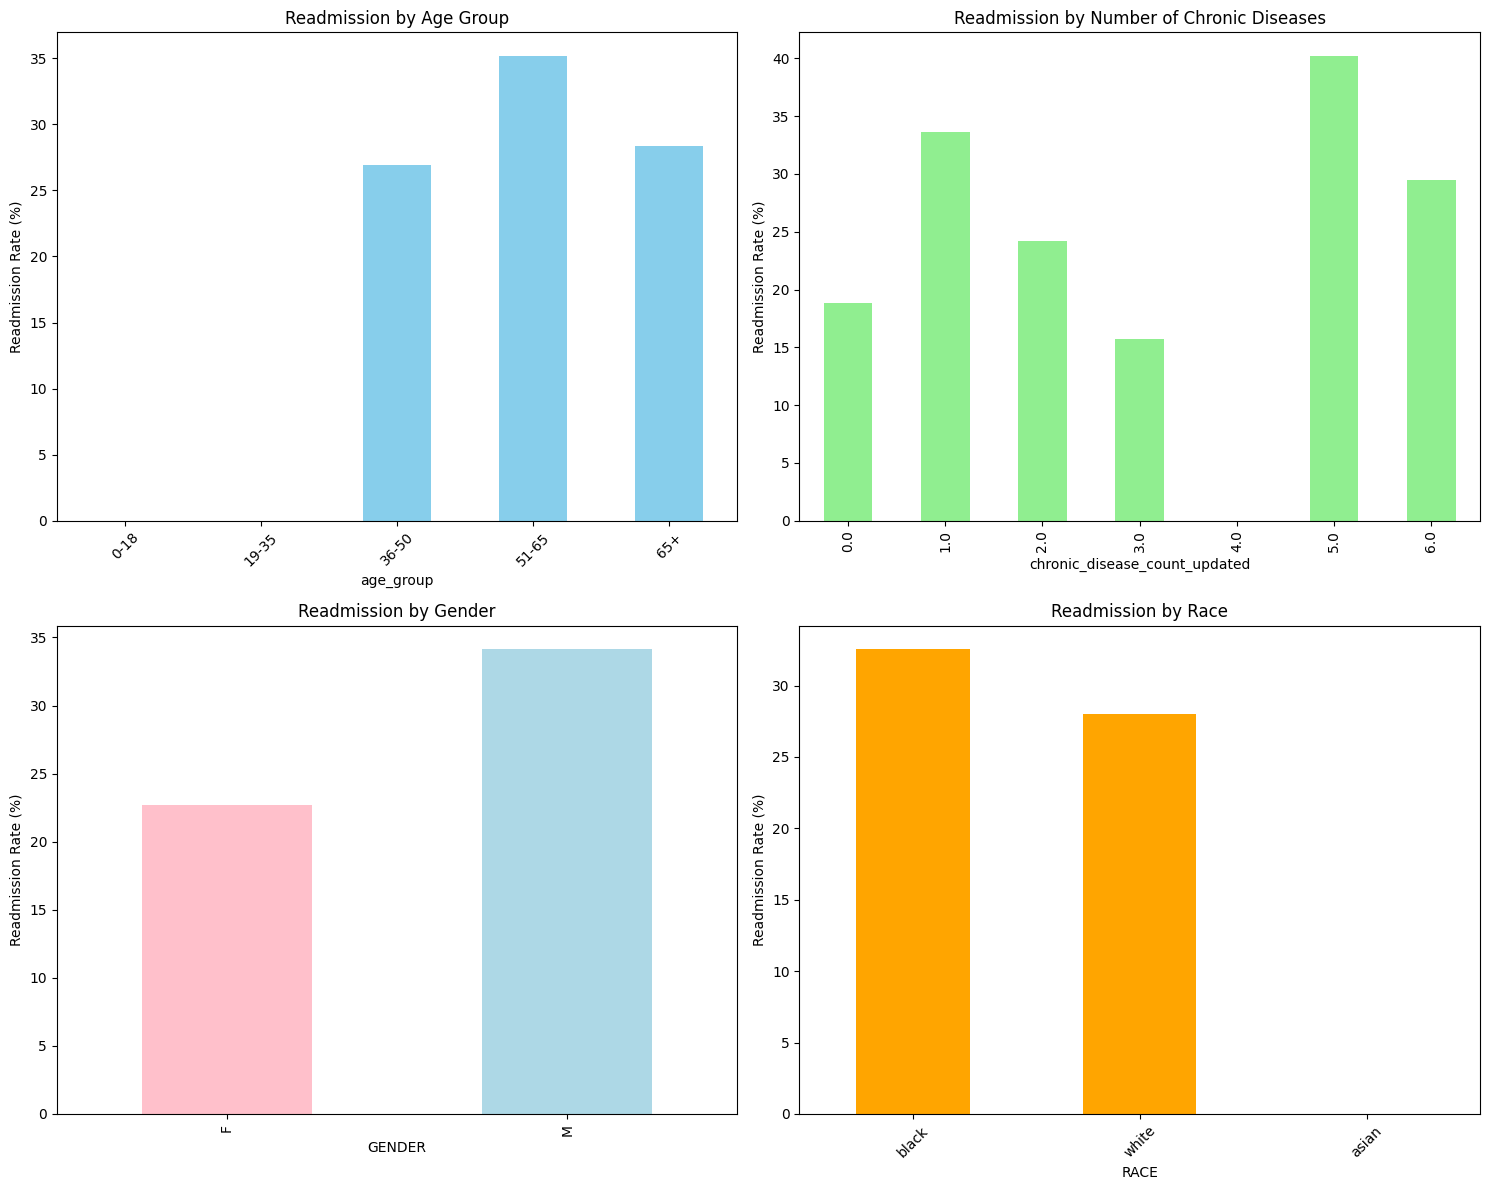

In [13]:
# visualizing the risk factors for readmission

plt.figure(figsize=(15, 12))

#readmission by age group
plt.subplot(2, 2, 1)
age_plot = readmission_with_demo.groupby('age_group')['readmission_30_days'].mean() * 100
age_plot.plot(kind='bar', color='skyblue')
plt.title('Readmission by Age Group')
plt.ylabel('Readmission Rate (%)')
plt.xticks(rotation=45)

# Readmission by Number of Chronic Diseases
plt.subplot(2, 2, 2)
chronic_plot = readmission_with_demo.groupby('chronic_disease_count_updated')['readmission_30_days'].mean() * 100
chronic_plot.plot(kind='bar', color='lightgreen')
plt.title('Readmission by Number of Chronic Diseases')
plt.ylabel('Readmission Rate (%)')

# Readmission by Gender
plt.subplot(2, 2, 3)
gender_plot = readmission_with_demo.groupby('GENDER')['readmission_30_days'].mean() * 100
gender_plot.plot(kind='bar', color=['pink', 'lightblue'])
plt.title('Readmission by Gender')
plt.ylabel('Readmission Rate (%)')

# Readmission by Race
plt.subplot(2, 2, 4)
race_plot = readmission_with_demo.groupby('RACE')['readmission_30_days'].mean() * 100
race_plot = race_plot.sort_values(ascending=False)
race_plot.plot(kind='bar', color='orange')
plt.title('Readmission by Race')
plt.ylabel('Readmission Rate (%)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [14]:
print("Sample sizes per chronic disease count:")
print(chronic_analysis_updated['total_admissions'])


Sample sizes per chronic disease count:
chronic_disease_count_updated
0.0    276
1.0    689
2.0    124
3.0    165
4.0     25
5.0     82
6.0     78
Name: total_admissions, dtype: int64
